This is the source code for the plots contained in the blog post, "[Design Considerations for a Spacecraft Solar Array](https://www.osborneee.com/spacecraft-solar-array/)."

In [1]:
from collections import namedtuple

import numpy as np
from matplotlib import pyplot as plt
from solarcell import solarcell
from worstcase import unit

# Cell Parameter Definitions

In [2]:
# units, note the currents are per area: V, mA/cm2, mV/C, uA/cm2/C
celltype = namedtuple("celltype", "name voc jsc vmp jmp dvoc djsc dvmp djmp")

# define triple-junction solar cells
spectrolab = celltype("Spectrolab XTJ", 2.72, 18.0, 2.41, 17.5, -5.6, 10.0, -6.3, 5.0)
azurspace = celltype("Azur Space 3G30A", 2.69, 17.2, 2.41, 16.7, -6.2, 11.9, -6.7, 8.0)
solaero = celltype("Solaero ZTJ", 2.73, 17.4, 2.41, 16.5, -6.3, 11.7, -6.7, 9.1)

In [3]:
def si(name, nseries, nparallel, area, voc, isc, vmp, imp, dvoc, disc, dpmp):
    # function to derive silicon cell paramters from a panel datasheet

    area = area * 0.90 / (nseries * nparallel)  # account for solar panel packing factor
    jsc = isc / nparallel / area / 0.72  # short circuit current at AM0
    jmp = imp / nparallel / area / 0.72  # max power current at AM0
    voc = voc / nseries  # open circuit voltage
    vmp = vmp / nseries  # max power voltage

    dvoc = (voc * dvoc).to("mV/K")
    djsc = (jsc * disc).to("uA/cm^2/K")
    dpmp = (vmp * jmp * dpmp).to("uW/cm^2/K")
    djmp = djsc  # rough assumption
    dvmp = ((dpmp - vmp * djmp) / jmp).to("mV/K")

    dt = (28 - 25) * unit.K  # adjust to space standard test temperature
    voc = (voc + dvoc * dt).to("V")
    jsc = (jsc + djsc * dt).to("mA/cm^2")
    vmp = (vmp + dvmp * dt).to("V")
    jmp = (jmp + djmp * dt).to("mA/cm^2")

    return celltype(name, voc.m, jsc.m, vmp.m, jmp.m, dvoc.m, djsc.m, dvmp.m, djmp.m)

In [4]:
# define monocrystalline-silicon solar cells
bluebird = si(
    name="Bluebird Mono PERC",
    nseries=72,
    nparallel=1,
    area=1985 * unit.mm * 1000 * unit.mm,
    voc=50.0 * unit.V,
    isc=10.0 * unit.A,
    vmp=40.7 * unit.V,
    imp=9.70 * unit.A,
    dvoc=-0.300e-2 / unit.K,
    disc=+0.060e-2 / unit.K,
    dpmp=-0.370e-2 / unit.K,
)
solartech = si(
    name="SolarTech EPIQ Black",
    nseries=60,
    nparallel=1,
    area=997 * unit.mm * 1663 * unit.mm,
    voc=40.1 * unit.V,
    isc=9.50 * unit.A,
    vmp=33.6 * unit.V,
    imp=8.90 * unit.A,
    dvoc=-0.280e-2 / unit.K,
    disc=+0.043e-2 / unit.K,
    dpmp=-0.366e-2 / unit.K,
)
jasolar = si(
    name="JA Solar DeepBlue",
    nseries=54,
    nparallel=1,
    area=1722 * unit.mm * 1134 * unit.mm,
    voc=36.6 * unit.V,
    isc=13.4 * unit.A,
    vmp=30.3 * unit.V,
    imp=12.6 * unit.A,
    dvoc=-0.275e-2 / unit.K,
    disc=+0.045e-2 / unit.K,
    dpmp=-0.350e-2 / unit.K,
)

In [5]:
# for all cells, compute the efficiency and temperature coefficient
cells = (azurspace, solaero, spectrolab, solartech, bluebird, jasolar)
intensity = 1365  # W/m2
dT = 60  # affects results only a little

for cell in cells:
    pmp = cell.vmp * cell.jmp  # mW
    pin = intensity / 100**2
    eff = pmp / pin / 1000

    x = cell.vmp * cell.djmp  # uW/C
    y = cell.dvmp * cell.jmp  # uW/C
    z = cell.dvmp * cell.djmp * dT  # nW/C
    dpmp = (x + y + z / 1000) * 1e-3  # mW/C
    deff = dpmp / pin / 1000

    result = (cell.name, eff * 100, round(deff * 1e6, -1))
    print("{:24s} {:.1f}%    {:.0f}ppm/C".format(*result))

Azur Space 3G30A         29.5%    -700ppm/C
Solaero ZTJ              29.1%    -680ppm/C
Spectrolab XTJ           30.9%    -730ppm/C
SolarTech EPIQ Black     20.2%    -770ppm/C
Bluebird Mono PERC       22.2%    -870ppm/C
JA Solar DeepBlue        21.9%    -800ppm/C


# Curve Fitting

In [6]:
def celltype2solarcell(type, area):
    return solarcell(
        isc=(type.jsc * area / 1e3, type.djsc * area / 1e6),
        voc=(type.voc, type.dvoc / 1e3),
        imp=(type.jmp * area / 1e3, type.djmp * area / 1e6),
        vmp=(type.vmp, type.dvmp / 1e3),
        area=area,
        t=28,
    )

In [7]:
c = celltype2solarcell(bluebird, 120)
c
# rint(c.isc, c.disc, c.voc, c.dvoc, c.imp, c.dimp, c.vmp, c.dvmp)

0 1.0000001301318544 -0.0005725018673736278 1.002060790523211
0.558139827718407 0.5579542253722795


Isc  = 6.729 A, Voc  = 0.6882 V
Imp  = 6.528 A, Vmp  = 0.5580 V, Pmp  = 3.642 W
Iunc = 0.000 A, Vunc = 0.0000 V, Punc = 0.000 W

0 1.000000130000505 -0.0010207351752321734 1.000270105607621
2.410100642612583 2.41
Isc  = 0.5160 A, Voc  = 2.690 V
Imp  = 0.5010 A, Vmp  = 2.410 V, Pmp  = 1.207 W
Iunc = 0.0000 A, Vunc = 0.000 V, Punc = 0.000 W


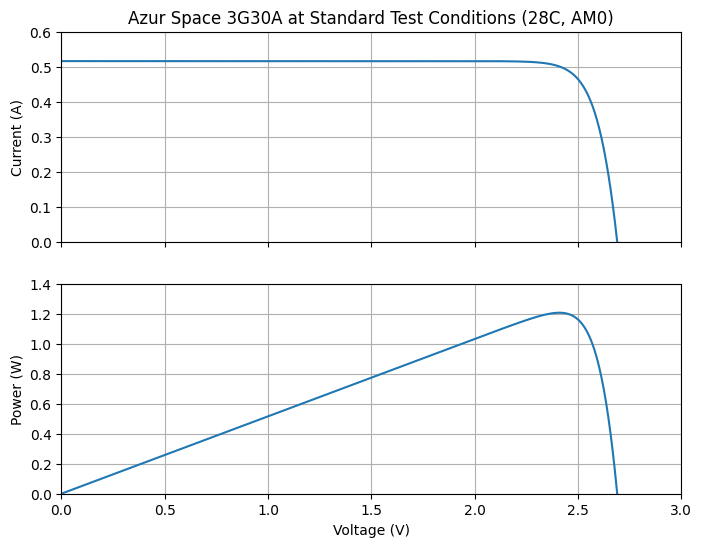

In [8]:
cell = celltype2solarcell(type=azurspace, area=30)

print(cell)

v = np.linspace(0, cell.voc, 1000)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
ax[0].plot(v, cell.iv(v))
ax[1].plot(v, cell.pv(v))
ax[0].set_ylabel("Current (A)")
ax[1].set_ylabel("Power (W)")
ax[1].set_xlabel("Voltage (V)")
ax[0].grid()
ax[1].grid()
ax[0].set_xlim((0, 3))
ax[0].set_ylim((0, 0.6))
ax[1].set_ylim((0, 1.4))
ax[0].set_title("Azur Space 3G30A at Standard Test Conditions (28C, AM0)")
plt.show()

In [ ]:
c = cell.cell(28, 1)
v = np.linspace(0, c.voc, 1000)
plt.plot(v / c.voc, c.iv(v) / c.isc, 'b', label="28C")
plt.plot(c.vmp / c.voc, c.imp / c.isc, 'bx')

c = cell.cell(-60, 1)
v = np.linspace(0, c.voc, 1000,)
plt.plot(v / c.voc, c.iv(v) / c.isc, 'r', label="-60C")
plt.plot(c.vmp / c.voc, c.imp / c.isc, 'rx')
plt.ylim([0.5, 1.1])
plt.xlim([0.5, 1.1])

plt.legend()
plt.grid()

0 1.000000130000505 -0.0010207351752321734 1.000270105607621
2.410100642612583 2.41


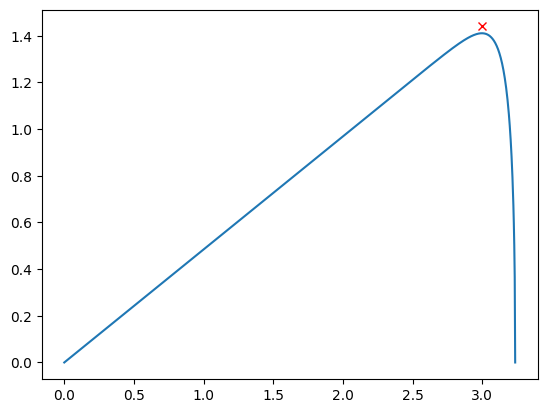

In [10]:
plt.plot(v, c.pv(v))
plt.plot(c.vmp, c.pmp, 'rx')

In [13]:
c.iv(0)

0.4845840000000486

In [19]:
c.vmp

2.9996

In [18]:
c.pv(c.vmp)

1.439448048

In [15]:
c

Isc  = 0.4846 A, Voc  = 3.236 V
Imp  = 0.4799 A, Vmp  = 3.000 V, Pmp  = 1.439 W
Iunc = 0.0000 A, Vunc = 0.000 V, Punc = 0.000 W

[-0.00015743  0.00072631]
Spectrolab XTJ @ -60C
[ 0.00011175 -0.00064468]
Isc  = 6.163 A, Voc  = 77.107 V
Imp  = 6.142 A, Vmp  = 71.146 V, Pmp  = 436.948 W
Iunc = 0.000 A, Vunc =  0.000 V, Punc =   0.000 W

Spectrolab XTJ @ 28C
[-0.00015743  0.00072631]
Isc  = 6.480 A, Voc  = 65.280 V
Imp  = 6.300 A, Vmp  = 57.840 V, Pmp  = 364.392 W
Iunc = 0.000 A, Vunc =  0.000 V, Punc =   0.000 W

Spectrolab XTJ @ 80C
[-0.00051234  0.00203277]
Isc  = 6.667 A, Voc  = 58.291 V
Imp  = 6.387 A, Vmp  = 50.031 V, Pmp  = 319.540 W
Iunc = 0.000 A, Vunc =  0.000 V, Punc =   0.000 W

[-1.69723795e-05  8.16945711e-05]
Azur Space 3G30A @ -60C
[ 0.00017999 -0.00111686]
Isc  = 5.815 A, Voc  = 77.654 V
Imp  = 5.759 A, Vmp  = 71.990 V, Pmp  = 414.561 W
Iunc = 0.000 A, Vunc =  0.000 V, Punc =   0.000 W

Azur Space 3G30A @ 28C
[-1.69723795e-05  8.16945711e-05]
Isc  = 6.192 A, Voc  = 64.560 V
Imp  = 6.012 A, Vmp  = 57.840 V, Pmp  = 347.734 W
Iunc = 0.000 A, Vunc =  0.000 V, Punc =   0.000 W

Azur Space 3G30A @ 80C
[-0

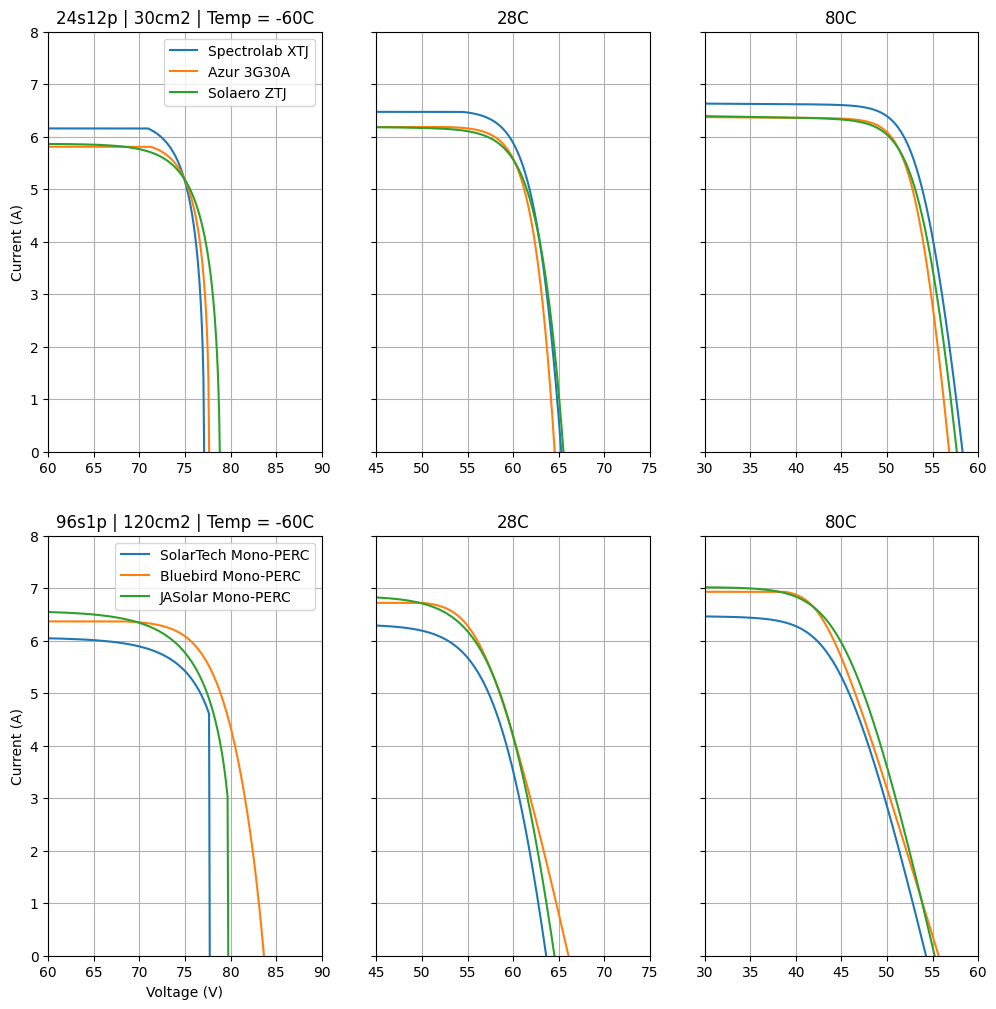

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12, 12))

for type in [spectrolab, azurspace, solaero]:
    sc = celltype2solarcell(type, area=30)
    for i, temp in enumerate([-60, 28, 80]):
        print("{:s} @ {:.0f}C".format(type.name, temp))
        array = sc.array(t=np.full((24, 12), temp), g=np.ones((24, 12)))
        v = np.linspace(0, array.voc, 1000)
        ax[0, i].plot(v, array.iv(v))
        print(array)
        print()

ax[0, 0].set_title("24s12p | 30cm2 | Temp = -60C")
ax[0, 0].set_xlim([60, 90]), ax[0, 0].grid()
ax[0, 1].set_xlim([45, 75]), ax[0, 1].grid(), ax[0, 1].set_title("28C")
ax[0, 2].set_xlim([30, 60]), ax[0, 2].grid(), ax[0, 2].set_title("80C")
ax[0, 0].legend(["Spectrolab XTJ", "Azur 3G30A", "Solaero ZTJ"])
ax[0, 0].set_ylabel("Current (A)")

for type in [solartech, bluebird, jasolar]:
    sc = celltype2solarcell(type, area=120)
    for i, temp in enumerate([-60, 28, 80]):
        print("{:s} @ {:.0f}C".format(type.name, temp))
        array = sc.array(t=np.full((96, 1), temp), g=np.ones((96, 1)))
        v = np.linspace(0, array.voc, 1000)
        ax[1, i].plot(v, array.iv(v))
        print(array)
        print()

ax[1, 0].set_title("96s1p | 120cm2 | Temp = -60C")
ax[1, 0].set_xlim([60, 90]), ax[1, 0].grid()
ax[1, 1].set_xlim([45, 75]), ax[1, 1].grid(), ax[1, 1].set_title("28C")
ax[1, 2].set_xlim([30, 60]), ax[1, 2].grid(), ax[1, 2].set_title("80C")
ax[1, 0].legend(["SolarTech Mono-PERC", "Bluebird Mono-PERC", "JASolar Mono-PERC"])
ax[1, 0].set_ylabel("Current (A)")
ax[1, 0].set_xlabel("Voltage (V)")

plt.ylim([0, 8])
plt.show()